In [2]:
pip install moviepy

     -------------------------------------- 388.3/388.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 22.6/22.6 MB 3.6 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110728 sha256=085dc9d66224e6db60bc8cea9120c0a0c1859f7498c87e974e977fd945aa0c3d
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\29\15\e4\4f790bec6acd51a00b67e8ee1394f0bc6e0135c315f8ff399a
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
def cam_calib():
    cx=9
    cy=6
    
    objpts=[]
    imgpts=[]
    
    #creating a 3d matrix for the chessboard
    threedim= np.zeros((6*9, 3),np.float32)
    # creating a meshgrid of coordinates with shape (cy, cx), which are then transposed and reshaped
    threedim[:,:2]= np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    os.listdir('C:/Users/Dell/Downloads/Advanced-Lane-Detection-master/Advanced-Lane-Detection-master/camera_cal/')
    cam_list= os.listdir('C:/Users/Dell/Downloads/Advanced-Lane-Detection-master/Advanced-Lane-Detection-master/camera_cal/')
    
    for img in cam_list:
        images= 'C:/Users/Dell/Downloads/Advanced-Lane-Detection-master/Advanced-Lane-Detection-master/camera_cal/' + img
        imgs=cv2.imread(images) #reading multiple images
        gray=cv2.cvtColor(imgs, cv2.COLOR_BGR2GRAY)#converting to grayscale images
        ret, corners= cv2.findChessboardCorners(gray,(cx,cy),None) #Finding the chessboard corners
        if ret==True:
            #If found draw corners, Draw and display corners
            cv2.drawChessboardCorners(imgs, (cx, cy), corners, ret)
            imgpts.append(corners)
            objpts.append(threedim)
            ret, mat, dist, rv, tv= cv2.calibrateCamera(objpts, imgpts, gray.shape[::-1],None, None)
            undist=cv2.undistort(imgs, mat, dist, None, mat)
            export_to = 'C:/Users/Dell/Downloads/lane outputs/calib output/' + img
            #save the image in the destination folder
            plt.imsave(export_to, undist)
    return mat, dist

mat, dist= cam_calib()    

In [3]:
def warp(imgs):
    undist= cv2.undistort(imgs, mat, dist, None, mat)
    img_size=(imgs.shape[1], imgs.shape[0])
    offset= 300
    # Source points taken from images with straight lane lines, these are to become parallel after the warp transform
    #Examining multiple images.
    src = np.float32([
        (190, 720), # bottom-left corner
        (596, 447), # top-left corner
        (685, 447), # top-right corner
        (1125, 720) # bottom-right corner
    ])
    
    # Destination points are to be parallel, taken into account the image size
    dst = np.float32([
        [offset, img_size[1]],             # bottom-left corner
        [offset, 0],                       # top-left corner
        [img_size[0]-offset, 0],           # top-right corner
        [img_size[0]-offset, img_size[1]]  # bottom-right corner
    ])
    
    # Then we calculate the transformation matrix and it's inverse transformation
    tm = cv2.getPerspectiveTransform(src, dst)
    tm_inv= cv2.getPerspectiveTransform(dst,src)
    warped=cv2.warpPerspective(undist, tm, img_size)
    
    return warped, tm_inv
    
        
    
    

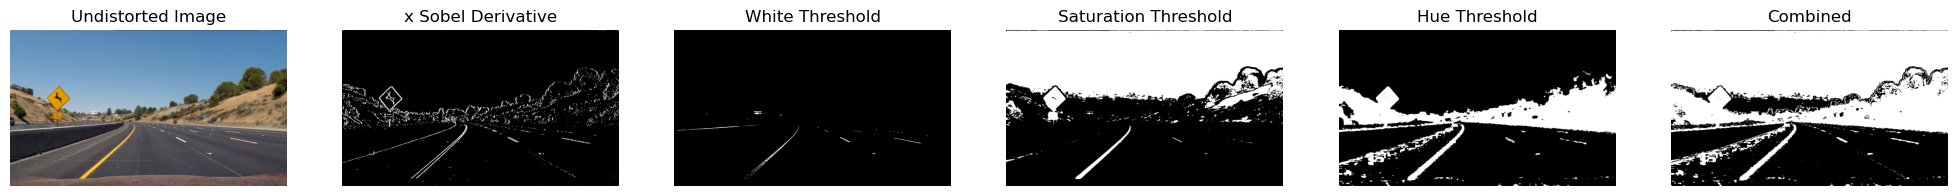

In [4]:
imgs= cv2.imread('C:/Users/Dell/Downloads/Advanced-Lane-Detection-master/Advanced-Lane-Detection-master/test_images/test2.jpg')

def bin_thres(img):
    gray_img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#Gray Conversion
    # Apply sobel in x direction
    sobelx=cv2.Sobel(gray_img, cv2.CV_64F,1,0)
    abs_sobelx=np.absolute(sobelx)
    sc_sobelx= np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    bin_sobx=np.zeros_like(sc_sobelx)
    bin_sobx[(sc_sobelx>=30)&(sc_sobelx<=255)]=1
    
    # Detecting white pixels
    w_bin= np.zeros_like(gray_img)
    w_bin[(gray_img>200) & (gray_img<=255)]=1
    
    # Convert image to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    S = hls[:,:,2]
    sat_binary = np.zeros_like(S)
    # Detect pixels that have a high saturation value
    sat_binary[(S > 90) & (S <= 255)] = 1

    hue_binary =  np.zeros_like(H)
    # Detect pixels that are yellow using the hue component
    hue_binary[(H > 10) & (H <= 25)] = 1

    # Combine all pixels detected above
    binary_1 = cv2.bitwise_or(bin_sobx, w_bin)
    binary_2 = cv2.bitwise_or(hue_binary, sat_binary)
    binary = cv2.bitwise_or(binary_1, binary_2)
#     plt.imshow(binary_1, cmap='gray')
#     plt.imshow(binary_2, cmap='gray')
#     plt.imshow(binary, cmap='gray')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     Draw figure for binary images
    f, axarr = plt.subplots(1,6)
    f.set_size_inches(25, 8)
    axarr[0].imshow(img)
    axarr[1].imshow(bin_sobx, cmap='gray')
    axarr[2].imshow(w_bin, cmap='gray')
    axarr[3].imshow(sat_binary, cmap='gray')
    axarr[4].imshow(hue_binary, cmap='gray')
    axarr[5].imshow(binary, cmap='gray')
    axarr[0].set_title("Undistorted Image")
    axarr[1].set_title("x Sobel Derivative")
    axarr[2].set_title("White Threshold")
    axarr[3].set_title("Saturation Threshold")
    axarr[4].set_title("Hue Threshold")
    axarr[5].set_title("Combined")
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[3].axis('off')
    axarr[4].axis('off')
    axarr[5].axis('off')
    return binary

out_img = bin_thres(imgs)    

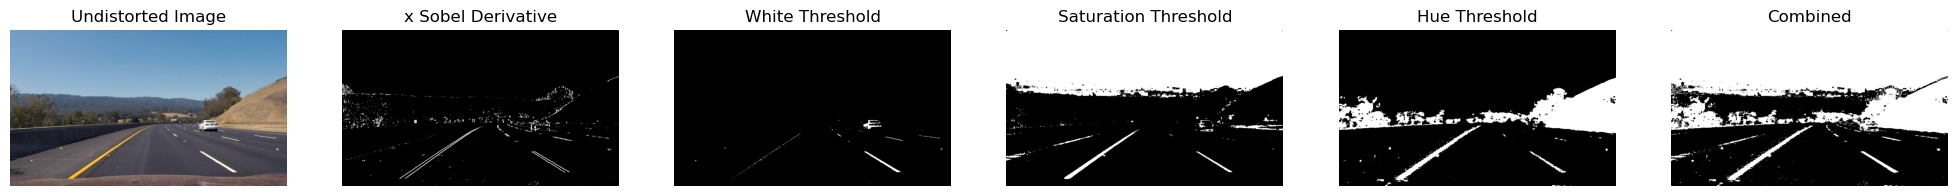

In [5]:
img = cv2.imread('C:/Users/Dell/Downloads/Advanced-Lane-Detection-master/Advanced-Lane-Detection-master/test_images/test3.jpg')

binary_thresh = bin_thres(img)
out_img = np.dstack((binary_thresh, binary_thresh, binary_thresh))*255
binary_warped, M_inv = warp(binary_thresh)
plt.imshow(out_img, cmap='gray')

In [6]:
def pix_histogram(binary_warped):
    # Finding the histogram of the ottom half of the image
    histogram =np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # FInding the peaks of left and right halves of histogram
    mid=np.int(histogram.shape[0]//2)
    left_base=np.argmax(histogram[:mid])
    right_base=np.argmax(histogram[mid:])+mid
    
    #Setting the parameters for the sliding window
    
    n_windows= 9 #No. of windows.
    margin=100 #Setting the width of the margin
    min_pix= 50 #Setting the minimum no. of pixels to recenter window
    window_h= np.int(binary_warped.shape[0]//n_windows)
    
    # Detecting the non zero pixels
    nz=binary_warped.nonzero()
    nz_x= np.array(nz[1])
    nz_y= np.array(nz[0])
    
    # Current positions to be updated later for each window
    left_current=left_base
    right_current=right_base
    
    # Create empty list for left and right lane pixels
    ll_idx=[]
    rl_idx=[]
    
    #step through the window one bu one
    
    for window in range(n_windows):
        #Identifying the window boundaries
        win_y_low = binary_warped.shape[0] - (window+1)*window_h
        win_y_high = binary_warped.shape[0] - window*window_h
        win_xleft_low = left_current - margin
        win_xleft_high = left_current + margin
        win_xright_low = right_current - margin
        win_xright_high = right_current + margin
        
        
        li=((nz_y>= win_y_low) & (nz_y < win_y_high) & (nz_x>= win_xleft_low) &  (nz_x< win_xleft_high)).nonzero()[0]
        ri=((nz_y>= win_y_low) & (nz_y < win_y_high) & (nz_x>= win_xright_low) &  (nz_x< win_xright_high)).nonzero()[0]
        
        ll_idx.append(li)
        rl_idx.append(ri)
        
        # If found > minpix pixels, recenter next window on their mean position
        
        if len(li)>min_pix:
            left_current= np.int(np.mean(nz_x[li]))
        if len(ri)> min_pix:
            right_current= np.int(np.mean(nz_x[ri]))
        # Concatenate the arrays of indices (previously was a list of lists of pixels)    
        try:
            ll_idx=np.concatenate(ll_idx)
            rl_idx= np.concatenate(rl_idx)
        except ValueError:
            pass
        
        # Extracting left and right line pixel positions
        leftx=nz_x[ll_idx]
        lefty=nz_y[ll_idx]
        rightx= nz_x[rl_idx]
        righty= nz_y[rl_idx]
        return leftx, lefty, rightx,righty    

In [7]:
a,b,c,d=pix_histogram(binary_warped)
print(b) 

[640 640 640 ... 719 719 719]


In [8]:
def fit_poly(binary_wrapped,leftx, lefty, rightx,righty):
    leftfit=np.polyfit(lefty, leftx,2)
    rightfit=np.polyfit(righty, rightx, 2)
    
    # Generating x and y values for plotting
    plot= np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        leftfitx= leftfit[0]*plot**2 + leftfit[1]*plot + leftfit[2]
        rightfitx = rightfit[0]*plot**2 + rightfit[1]*plot + rightfit[2]
    except TypeError:
        print('Function Failed')
        leftfitx= 1*plot**2 +1*plot
        rightfitx= 1*plot**2 +1*plot
        
    return leftfit, rightfit, leftfitx, rightfitx, plot



In [9]:
q,w,e,r,t= fit_poly(binary_warped, a,b,c,d)
print(q,w,e,r,t)

[ 6.79621564e-04 -1.09920619e+00  7.73055435e+02] [-5.60232467e-04  6.11719312e-01  8.38576702e+02] [773.0554352  771.95690863 770.8597413  769.76393322 768.66948438
 767.57639478 766.48466442 765.39429331 764.30528144 763.21762882
 762.13133543 761.04640129 759.9628264  758.88061074 757.79975433
 756.72025716 755.64211924 754.56534056 753.48992112 752.41586093
 751.34315997 750.27181826 749.2018358  748.13321258 747.0659486
 746.00004386 744.93549837 743.87231212 742.81048511 741.75001735
 740.69090883 739.63315955 738.57676952 737.52173873 736.46806718
 735.41575487 734.36480181 733.31520799 732.26697342 731.22009808
 730.174582   729.13042515 728.08762755 727.04618919 726.00611007
 724.9673902  723.93002957 722.89402818 721.85938603 720.82610313
 719.79417948 718.76361506 717.73440989 716.70656396 715.68007727
 714.65494983 713.63118163 712.60877268 711.58772296 710.56803249
 709.54970127 708.53272928 707.51711654 706.50286305 705.48996879
 704.47843378 703.46825801 702.45944149 701

In [10]:
def draw_polylines(leftfit, rightfit, leftfitx, rightfitx, plot):
    # Create an image to show the selected window
    out_img= np.dstack((binary_warped, binary_warped, binary_warped))*255
    win_img= np.zeros_like(out_img)
    margin=100
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    
    leftline_win1= np.array([np.transpose(np.vstack([leftfitx-margin, plot]))])
    leftline_win2 = np.array([np.flipud(np.transpose(np.vstack([leftfitx+margin,plot])))])
    leftline_pts= np.hstack((leftline_win1, leftline_win2))
    rightline_win1= np.array([np.transpose(np.vstack([rightfitx-margin, plot]))])
    rightline_win2= np.array([np.flipud(np.transpose(np.vstack([rightfitx+margin,plot])))])
    rightline_pts= np.hstack((rightline_win1, rightline_win2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(win_img, np.int_([leftline_pts]), (100, 100, 0))
    cv2.fillPoly(win_img, np.int_([rightline_pts]), (100, 100, 0))
    result = cv2.addWeighted(out_img, 1, win_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(leftfitx, plot, color='red')
    plt.plot(rightfitx, plot, color='blue')
    ## End visualization steps ##
    return result

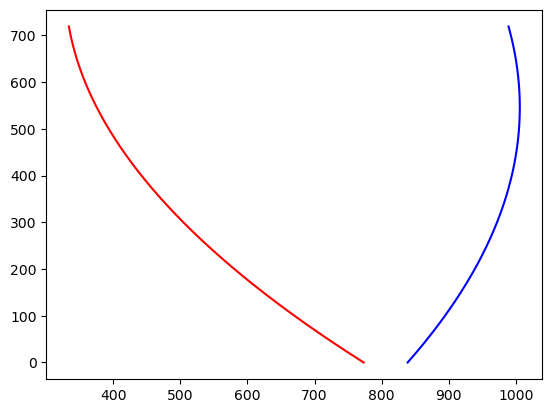

In [11]:
res= draw_polylines(q,w,e,r,t)

In [15]:
prevlfit, prevrfit = q, w
print('prev left fit: ', prevlfit)
print('prev right fit: ', prevrfit)

prev left fit:  [ 6.79621564e-04 -1.09920619e+00  7.73055435e+02]
prev right fit:  [-5.60232467e-04  6.11719312e-01  8.38576702e+02]


In [16]:
def lane_det_prev_poly(binary_warped):
    global prevlfit
    global prevrfit
#     prevlfit=[0,0,0]
#     prevrfit=[0,0,0]
    
    margin=100
    
    nz= binary_warped.nonzero()
    nz_x=np.array(nz[1])
    nz_y=np.array(nz[0])
    
    ll_idx=((nz_x > (prevlfit[0]*(nz_y**2) + prevlfit[1]*nz_y +prevlfit[2] - margin)) & (nz_x < (prevlfit[0]*(nz_y**2) +prevlfit[1]*nz_y + prevlfit[2] + margin))).nonzero()[0]
    rl_idx = ((nz_x > (prevrfit[0]*(nz_y**2) + prevrfit[1]*nz_y + prevrfit[2] - margin)) & (nz_x < (prevrfit[0]*(nz_y**2) + prevrfit[1]*nz_y + prevrfit[2] + margin))).nonzero()[0]
    # Again, extract left and right line pixel positions
    leftx = nz_x[ll_idx]
    lefty = nz_y[ll_idx] 
    rightx = nz_x[rl_idx]
    righty = nz_y[rl_idx]

    return leftx, lefty, rightx, righty


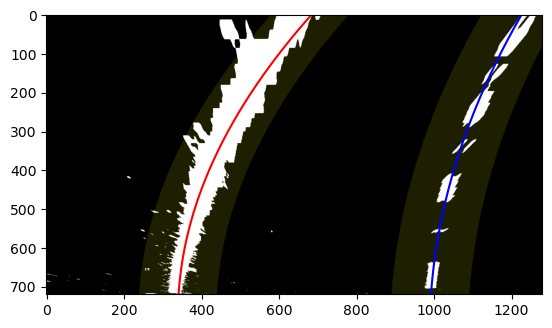

In [17]:
z,x,c,v=lane_det_prev_poly(binary_warped)
left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,z,x,c,v)
out_img = draw_polylines(left_fit, right_fit, left_fitx, right_fitx, ploty)
plt.imshow(out_img)

In [18]:
def curvature(binary_warped, leftfitx, rightfitx, plot):
    y_m_ppix=30/720
    x_m_ppix=3.7/700
    
    leftfitcr = np.polyfit(ploty*y_m_ppix, left_fitx*x_m_ppix, 2)
    rightfitcr = np.polyfit(ploty*y_m_ppix, right_fitx*x_m_ppix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_r=((1 + (2*leftfitcr[0]*y_eval*y_m_ppix + leftfitcr[1])**2)**1.5) / np.absolute(2*leftfitcr[0])
    right_r = ((1 + (2*rightfitcr[0]*y_eval*y_m_ppix + rightfitcr[1])**2)**1.5) / np.absolute(2*rightfitcr[0])
    
    return left_r, right_r

In [19]:
lr,rr= curvature(binary_warped, left_fitx, right_fitx, ploty)
print(lr)
print(rr)

287.613873747644
470.5537572859195


In [20]:
def meas_pos(binary_warped, left_fit, right_fit):
    x_m_ppix=3.7/700
    # Choose the y value corresponding to the bottom of the image
    y_max = binary_warped.shape[0]
    # Calculate left and right line positions at the bottom of the image
    leftx_pos = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    rightx_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2] 
    # Calculate the x position of the center of the lane 
    centerlanesx_pos = (leftx_pos + rightx_pos)//2
    # Calculate the deviation between the center of the lane and the center of the picture
    # The car is assumed to be placed in the center of the picture
    # If the deviation is negative, the car is on the felt hand side of the center of the lane
    veh_pos = ((binary_warped.shape[1]//2) - centerlanesx_pos) * x_m_ppix 
    return veh_pos
    
    

In [21]:
veh_pos = meas_pos(binary_warped, left_fit, right_fit)
print('vehicle position rel to center  = ', veh_pos)

vehicle position rel to center  =  -0.13742857142857143


In [22]:
def lane_info(img, binary_warped, ploty, left_fitx, right_fitx, M_inv, left_curverad, right_curverad, veh_pos):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0]))
    
    # Combine the result with the original image
    out_img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    cv2.putText(out_img,'Curve Radius [m]: '+str((left_curverad+right_curverad)/2)[:7],(40,70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6, (255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img,'Center Offset [m]: '+str(veh_pos)[:7],(40,150), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6,(255,255,255),2,cv2.LINE_AA)
    
    return out_img

Text(0.5, 1.0, 'Image With Lane Marked')

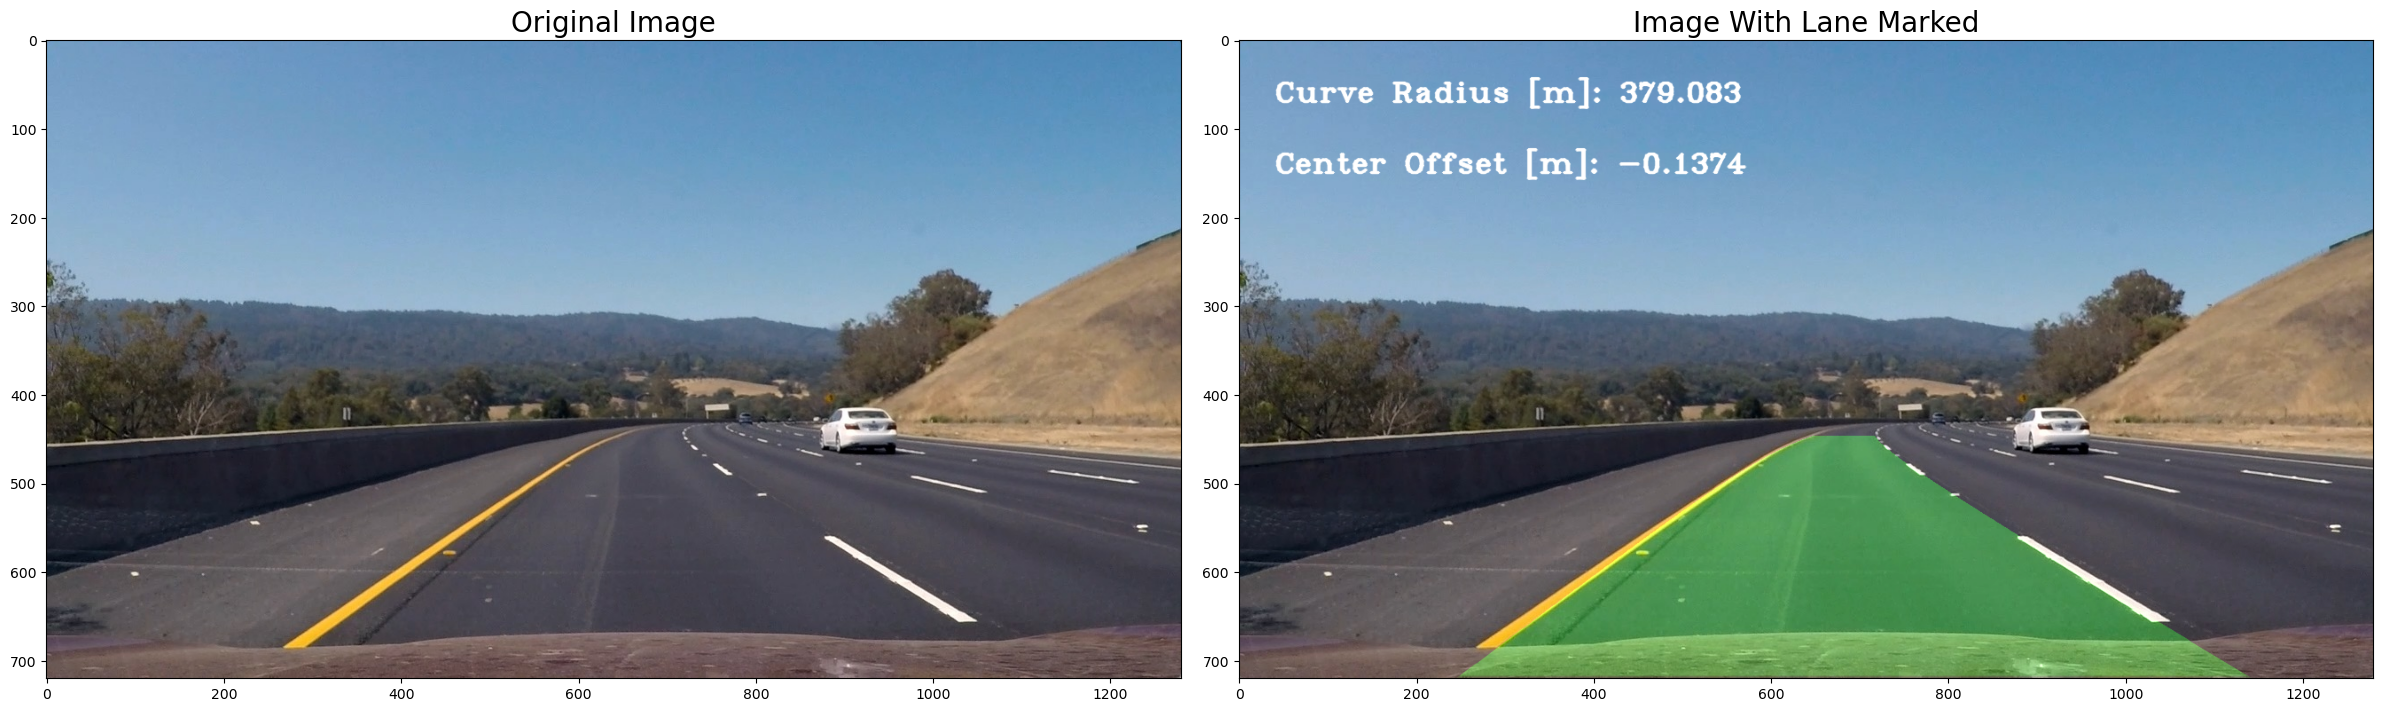

In [23]:
new_img = lane_info(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), binary_warped, ploty, left_fitx, right_fitx, M_inv, lr, rr, veh_pos)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(new_img, cmap='gray')
ax2.set_title('Image With Lane Marked', fontsize=20)

In [24]:
global left_fit_hist 
left_fit_hist = np.array([])
#print(len(left_fit_hist))

global right_fit_hist 
right_fit_hist = np.array([])


left_fit_hist = np.array(left_fit)
print(len(left_fit_hist))
new_fit = np.array(left_fit)
left_fit_hist = np.vstack([left_fit_hist, new_fit])
new_fit = np.array(left_fit)
left_fit_hist = np.vstack([left_fit_hist, new_fit])
print(left_fit_hist)
print(len(left_fit_hist))
prev_left_fit = [np.mean(left_fit_hist[:,0]), np.mean(left_fit_hist[:,1]), np.mean(left_fit_hist[:,2])]
left_fit_hist = np.delete(left_fit_hist, 0,0)

right_fit_hist = np.array(right_fit)
print(len(right_fit_hist))
new_fit = np.array(right_fit)
right_fit_hist = np.vstack([right_fit_hist, new_fit])
new_fit = np.array(left_fit)
right_fit_hist = np.vstack([right_fit_hist, new_fit])
print(right_fit_hist)
print(len(right_fit_hist))
prev_right_fit = [np.mean(right_fit_hist[:,0]), np.mean(right_fit_hist[:,1]), np.mean(right_fit_hist[:,2])]
right_fit_hist = np.delete(right_fit_hist, 0,0)


print(left_fit_hist)
print(prev_left_fit)

3
[[ 5.71053401e-04 -8.85008993e-01  6.81906712e+02]
 [ 5.71053401e-04 -8.85008993e-01  6.81906712e+02]
 [ 5.71053401e-04 -8.85008993e-01  6.81906712e+02]]
3
3
[[ 3.49051592e-04 -5.74390087e-01  1.22465615e+03]
 [ 3.49051592e-04 -5.74390087e-01  1.22465615e+03]
 [ 5.71053401e-04 -8.85008993e-01  6.81906712e+02]]
3
[[ 5.71053401e-04 -8.85008993e-01  6.81906712e+02]
 [ 5.71053401e-04 -8.85008993e-01  6.81906712e+02]]
[0.000571053400673929, -0.8850089930239985, 681.9067120533181]


In [ ]:
def lane_finding_pipeline(img):
    global left_fit_hist 
    global right_fit_hist
    global prev_left_fit
    global prev_right_fit
    binary_thresh = bin_thres(img)
    binary_warped, M_inv = warp(binary_thresh)
    #out_img = np.dstack((binary_thresh, binary_thresh, binary_thresh))*255
    
    if (len(left_fit_hist) == 0):
        leftx, lefty, rightx, righty = pix_histogram(binary_warped)
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty)
        # Store fit in history
        left_fit_hist = np.array(left_fit)
        new_left_fit = np.array(left_fit)
        left_fit_hist = np.vstack([left_fit_hist, new_left_fit])
        right_fit_hist = np.array(right_fit)
        new_right_fit = np.array(right_fit)
        right_fit_hist = np.vstack([right_fit_hist, new_right_fit])
    else:
        prev_left_fit = [np.mean(left_fit_hist[:,0]), np.mean(left_fit_hist[:,1]), np.mean(left_fit_hist[:,2])]
        prev_right_fit = [np.mean(right_fit_hist[:,0]), np.mean(right_fit_hist[:,1]), np.mean(right_fit_hist[:,2])]
        leftx, lefty, rightx, righty = pix_histogram(binary_warped)
        if (len(lefty) == 0 or len(righty) == 0):
            leftx, lefty, rightx, righty = pix_histogram(binary_warped)
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty)
        
        # Add new values to history
        new_left_fit = np.array(left_fit)
        left_fit_hist = np.vstack([left_fit_hist, new_left_fit])
        new_right_fit = np.array(right_fit)
        right_fit_hist = np.vstack([right_fit_hist, new_right_fit])
        
        # Remove old values from history
        if (len(left_fit_hist) > 10):
            left_fit_hist = np.delete(left_fit_hist, 0,0)
            right_fit_hist = np.delete(right_fit_hist, 0,0)
                                       
    left_curverad, right_curverad =  curvature(binary_warped, left_fitx, right_fitx, ploty)
                                     #measure_curvature_meters(binary_warped, left_fitx, right_fitx, ploty)
    veh_pos = meas_pos(binary_warped, left_fit, right_fit) 
    out_img = lane_info(img, binary_warped, ploty, left_fitx, right_fitx, M_inv, left_curverad, right_curverad, veh_pos)
    return out_img

video_output = 'C:/Users/Dell/Downloads/lane outputs/project_video_hard152123_output.mp4'
clip1 = VideoFileClip("C:/Users/Dell/Downloads/Roadseg_share/Roadseg_share/archive/testing/harder_challenge_video.mp4")
output_clip = clip1.fl_image(lane_finding_pipeline)
%time output_clip.write_videofile(video_output, audio=False)
